In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'buckeye'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'phones.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key,rate,spectrogram
0,4.885333,4.988600,w,well,0,0,0,0,s07,0,o,f,s0702b,16000,"[[2, 2, 2, 2, 0, 44, 79, 95, 86, 81, 77, 38, 3..."
1,4.988600,5.114649,eh,well,1,0,1,0,s07,0,o,f,s0702b,16000,"[[4, 4, 174, 166, 164, 162, 160, 159, 159, 161..."
2,5.114649,5.255262,l,well,2,0,2,0,s07,0,o,f,s0702b,16000,"[[5, 5, 170, 156, 156, 154, 151, 149, 147, 144..."


In [6]:
np.shape(syllable_df.spectrogram.values[0])

(32, 24)

### project

In [7]:
specs = list(syllable_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(837207, 768)

In [8]:
min_dist = 0.5
cuml_umap = cumlUMAP(min_dist = min_dist)
embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
syllable_df['umap'] = list(embedding)

In [10]:
syllable_df[:3]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key,rate,spectrogram,umap
0,4.885333,4.988600,w,well,0,0,0,0,s07,0,o,f,s0702b,16000,"[[2, 2, 2, 2, 0, 44, 79, 95, 86, 81, 77, 38, 3...","[2.356422185897827, 0.031862981617450714]"
1,4.988600,5.114649,eh,well,1,0,1,0,s07,0,o,f,s0702b,16000,"[[4, 4, 174, 166, 164, 162, 160, 159, 159, 161...","[0.8278802037239075, -5.5014262199401855]"
2,5.114649,5.255262,l,well,2,0,2,0,s07,0,o,f,s0702b,16000,"[[5, 5, 170, 156, 156, 154, 151, 149, 147, 144...","[2.133000612258911, -4.7591471672058105]"


(-8, 8)

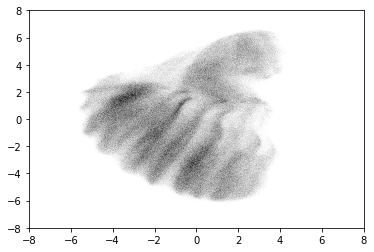

In [11]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=1, color='k', alpha = 0.005)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])

### Save

In [12]:
ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'human_full')

In [13]:
syllable_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / (str(min_dist) + '_humans_full.pickle'))